## Audio load + resample benchmark

Let's do a loading + resampling combo benchmark. The idea is to benchmark the time it takes to load a file from disk, resample it and convert it to a pytorch tensor. We'll resample from 44.1 kHz to 16 kHz.

Methods are:
- Method 1 : torchaudio load + torchaudio resample
- Method 2 : librosa load + resample + convert to torch tensor
- Method 3 : soundfile load + resample + convert to torch tensor
- Method 4 : scipy load + resample + convert to torch tensor

and a few more.

### Setup: save the following snippet as generate_audio.sh:



```bash
#!/usr/bin/env bash

# Set the number of files to generate
NBFILES=10
DIR=AUDIO

mkdir $DIR
for k in $(seq -f "%02g" 1 10 151); do
    mkdir $DIR/$k
    for i in $(seq 1 $NBFILES); do
        sox -n -r 44100 -b 16 $DIR/$k/$i.wav synth "0:$k" whitenoise vol 0.5 fade q 1 "0:$k" 1
    done
done
```

Then run it to generate some audio files at 44.1 kHz:

In [2]:
import torch, torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io import wavfile
import numpy as np
import librosa
import pandas as pd

import scipy.signal
import resampy
import lilfilter  # https://github.com/danpovey/filtering
import julius  # https://github.com/adefossez/julius
import soxr  # https://github.com/dofuuz/python-soxr
import nnresample  # https://github.com/jthiem/nnresample

### Resampling functions

In [3]:
def resample_scipy(sig, P, Q):
    return scipy.signal.resample(sig, int(len(sig)*Q/P))

def resample_resampy_best(sig, P, Q):
    return resampy.resample(sig, P, Q, filter='kaiser_best')

def resample_resampy_fast(sig, P, Q):
    return resampy.resample(sig, P, Q, filter='kaiser_fast')


def resample_torchaudio_hann(sig, P, Q):
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return F.resample(sig, P, Q, resampling_method='sinc_interp_hann')

def resample_torchaudio_kaiser(sig, P, Q):
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return F.resample(sig, P, Q, resampling_method='sinc_interp_kaiser')

def resample_torchaudio_transform_hann(sig, P, Q, get_resampler=False):
    
    resampler = torchaudio.transforms.Resample(
        P,
        Q,
        resampling_method='sinc_interp_hann',
)
    if get_resampler:
        return resampler
    
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return resampler(sig)

def resample_torchaudio_transform_kaiser(sig, P, Q, get_resampler=False):
    resampler = torchaudio.transforms.Resample(
        P,
        Q,
        resampling_method='sinc_interp_kaiser',
)
    if get_resampler:
        return resampler
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return resampler(sig)


def resample_julius(sig, P, Q):
    # If numpy convert to torch
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float() 
    return julius.resample_frac(sig, P, Q)

def resample_soxr(sig, P, Q):
    return soxr.resample(sig, P, Q)

def resample_nnresample(sig, P, Q):
    return nnresample.resample(sig, Q, P)


### Load functions

In [4]:
def load_torchaudio(fp):
    sig, rate = torchaudio.load(fp)
    return sig.squeeze()

def load_soundfile(fp):
    sig, rate = sf.read(fp)
    return sig

def load_scipy(fp):
    rate, sig = wavfile.read(fp)
    sig = sig.astype('float32') / 32767
    return sig


def load_librosa(fp):
    # loading with `sr=None` is disabling the internal resampling
    sig, rate = librosa.load(fp, sr=None)
    return sig

### Data loading

In [5]:

import os
import os.path
import timeit
import argparse
import numpy as np
import functools


def get_files(dir, extension):
    audio_files = []
    dir = os.path.expanduser(dir)
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if fname.endswith(extension):
                path = os.path.join(root, fname)
                item = path
                audio_files.append(item)
    return audio_files


class DF_writer(object):
    def __init__(self, columns):
        self.df = pd.DataFrame(columns=columns)
        self.columns = columns

    def append(self, **row_data):
        # Use concat to append to dataframe
        self.df = pd.concat([self.df, pd.DataFrame(row_data, index=[0])], ignore_index=True)

class AudioFolder(torch.utils.data.Dataset):
    def __init__(
        self,
        root,
        sample_rate=44100,
        resample_rate=16000,
        extension='wav',
        load_lib="librosa",
        resample_lib="scipy",
    ):
        self.root = os.path.expanduser(root)
        self.data = []
        self.sample_rate = sample_rate
        self.resample_rate = resample_rate
        self.audio_files = get_files(dir=self.root, extension=extension)
        self.loader_function = globals()['load_%s' % load_lib]
        self.resample_lib = resample_lib
        if 'transform' in resample_lib:
            # Call the function to get the resampler
            self.resample_function = globals()['resample_%s' % resample_lib](None, sample_rate, resample_rate, get_resampler=True)
        else:
            self.resample_function = globals()['resample_%s' % resample_lib]
        # if

    def __getitem__(self, index):
        audio = self.loader_function(self.audio_files[index])
        args = (self.sample_rate, self.resample_rate) if 'transform' not in self.resample_lib else []
        audio = self.resample_function(audio, *args)
        return torch.as_tensor(audio).view(1, 1, -1)

    def __len__(self):
        return len(self.audio_files)
    

### Speed benchmark

In [23]:
import os
import time

ext = 'wav'
columns = [
        'ext',
        'load_lib',
        'resamp_lib',
        'duration',
        'time',
    ]

repeat = 3
SR = 44100
RSR = 16000


store = DF_writer(columns)

# audio formats to be bench
# libraries to be benchmarked
load_libs = [
    'scipy',
    'librosa',
    'soundfile',
    'torchaudio_sox_io',
    'torchaudio_sox_io',
    'torchaudio_soundfile',
    'torchaudio_soundfile',
    'torchaudio_soundfile',
    'torchaudio_sox_io',
    'torchaudio_soundfile',
    'torchaudio_soundfile',
]

resamping_libs = [
    'soxr',
    'soxr',
    'soxr',
    'torchaudio_hann',
    'torchaudio_kaiser',
    'torchaudio_hann',
    'torchaudio_kaiser',
    'soxr',
    'soxr',
    'torchaudio_transform_hann',
    'julius',
]
    

for load_lib, resamp_lib in zip(load_libs, resamping_libs):
    print("Testing: ", load_lib, resamp_lib)
    if "torchaudio" in load_lib:
        backend = load_lib.split("torchaudio_")[-1]
        import torchaudio
        torchaudio.set_audio_backend(backend)
        call_lib = "torchaudio"
    else:
        call_lib = load_lib

    for root, dirs, fnames in sorted(os.walk('AUDIO')):
        for audio_dir in dirs:
            try:
                duration = int(audio_dir)
                data = torch.utils.data.DataLoader(
                    AudioFolder(
                        os.path.join(root, audio_dir),
                        sample_rate=SR,
                        resample_rate=RSR,
                        load_lib=call_lib,
                        resample_lib=resamp_lib,
                        extension=ext
                    ),
                    batch_size=1,
                    num_workers=0,
                    shuffle=False
                )
                start = time.time()

                for i in range(repeat):
                    for X in data:
                        X.max()

                end = time.time()
                store.append(
                    ext=ext,
                    load_lib=load_lib,
                    resamp_lib=resamp_lib,
                    duration=duration,
                    time=float(end-start) / (len(data) * repeat),
                )
            except:
                # "Error but continue"
                # continue
                raise

store.df.to_pickle("results_benchmark.pickle")

Testing:  scipy soxr


/tmp/ipykernel_36700/1578768373.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, pd.DataFrame(row_data, index=[0])], ignore_index=True)


Testing:  librosa soxr
Testing:  soundfile soxr
Testing:  torchaudio_sox_io torchaudio_hann


/tmp/ipykernel_36700/4083240806.py:56: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend(backend)


Testing:  torchaudio_sox_io torchaudio_kaiser
Testing:  torchaudio_soundfile torchaudio_hann
Testing:  torchaudio_soundfile torchaudio_kaiser
Testing:  torchaudio_soundfile soxr
Testing:  torchaudio_sox_io soxr
Testing:  torchaudio_soundfile torchaudio_transform_hann
Testing:  torchaudio_soundfile julius


In [24]:
store.df

,ext,load_lib,resamp_lib,duration,time
0,wav,scipy,soxr,121,0.045113
1,wav,scipy,soxr,131,0.049549
2,wav,scipy,soxr,101,0.037494
3,wav,scipy,soxr,111,0.040844
4,wav,scipy,soxr,151,0.053035
...,...,...,...,...,...
171,wav,torchaudio_soundfile,julius,91,0.042692
172,wav,torchaudio_soundfile,julius,41,0.025531
173,wav,torchaudio_soundfile,julius,51,0.030890
174,wav,torchaudio_soundfile,julius,11,0.014049


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

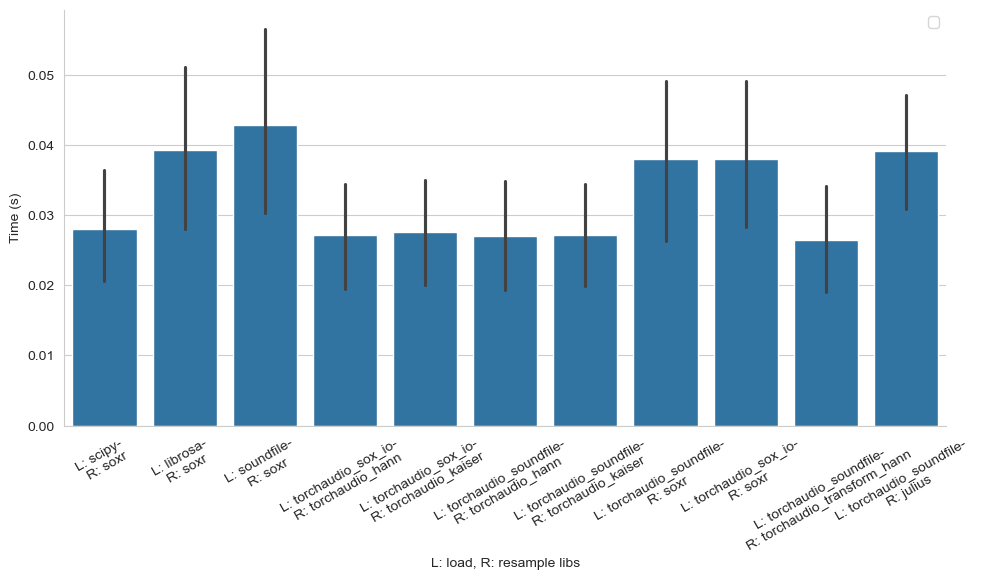

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


dfs = []
try:
    dfs.append(
        pd.read_pickle("results/benchmark.pickle")
    )
except FileNotFoundError:
    df = store.df.copy()

# df = pd.concat(dfs, ignore_index=True)

sns.set_style("whitegrid")

# Merge load_lib and resamp_lib into one column
df['L: load, R: resample libs'] = 'L: ' + df['load_lib'] + '- \n' + 'R: ' + df['resamp_lib']
df = df.drop(columns=['resamp_lib'])
df = df.drop(columns=['load_lib'])

fig = plt.figure()

# Cat plot, with load_lib on x-axis and time on y-axis
g = sns.catplot(x="L: load, R: resample libs", y="time", data=df, kind='bar', height=5, aspect=2)
g.set_xticklabels(rotation=30)

plt.legend(loc='upper right')
plt.ylabel("Time (s)")
g.savefig("benchmark_%s.png")

In [27]:
df['time'] = pd.to_numeric(df['time'], errors='coerce')
results = df.groupby('L: load, R: resample libs')['time'].mean() * 1000

In [28]:
results.sort_values()

L: load, R: resample libs
L: torchaudio_soundfile- \nR: torchaudio_transform_hann    26.424762
L: torchaudio_soundfile- \nR: torchaudio_hann              27.050398
L: torchaudio_sox_io- \nR: torchaudio_hann                 27.127326
L: torchaudio_soundfile- \nR: torchaudio_kaiser            27.153835
L: torchaudio_sox_io- \nR: torchaudio_kaiser               27.646094
L: scipy- \nR: soxr                                        28.060912
L: torchaudio_sox_io- \nR: soxr                            37.961860
L: torchaudio_soundfile- \nR: soxr                         37.999496
L: torchaudio_soundfile- \nR: julius                       39.168839
L: librosa- \nR: soxr                                      39.238550
L: soundfile- \nR: soxr                                    42.834313
Name: time, dtype: float64